# 0.0. IMPORTS

In [2]:
import pandas            as pd
import regex             as re
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import xgboost           as xgb
import lightgbm          as lgb

from pycorrcat import pycorrcat

from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model  import LinearRegression, Lasso

from sklearn               import model_selection   as ms
from sklearn               import ensemble          as en

f:\SamuelOliveiraAlvesd\Anaconda3\envs\Health_Insurance_Cross_Sell\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 0.1. Aux Functions

In [3]:
def settings():
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    plt.rcParams['figure.dpi'] = 100
    sns.set()


def ml_error( model_name, ytest, yhat ):
    mae = mean_absolute_error( ytest, yhat )
    mape = mean_absolute_percentage_error( ytest, yhat )
    rmse = np.sqrt( mean_squared_error( ytest, yhat ) )
    
    return pd.DataFrame( {'Model name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse }, index=[0] )

def analise_bivariada(df,column):
    aux1=df[[column,'preco']].groupby(column).mean().reset_index()
    aux2=df[[column,'preco']].groupby(column).median().reset_index()
    plt.figure(figsize=(15,10))
    plt.subplot(2,1,1)
    sns.barplot(x=column,y='preco',data=aux1)
    plt.subplot(2,1,2)
    sns.barplot(x=column,y='preco',data=aux2)

In [4]:
settings()

## 0.2. Reading Data

In [5]:
df_raw=pd.read_csv('work/treino.csv')
df_test=pd.read_csv('work/teste.csv')

# 1.0. DESCRIÇÃO DOS DADOS

In [6]:
df1=df_raw.copy()
df1.columns=['id', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'odometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'tipo_anuncio', 'entrega_delivery', 'troca', 'elegivel_revisao',
       'attr_veiculo_aceita_troca', 'attr_veiculo_único_dono',
       'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fábrica',
       'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',
       'attr_veiculo_alienado', 'preco']
df1.columns

Index(['id', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'odometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'tipo_anuncio', 'entrega_delivery', 'troca', 'elegivel_revisao',
       'attr_veiculo_aceita_troca', 'attr_veiculo_único_dono',
       'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fábrica',
       'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',
       'attr_veiculo_alienado', 'preco'],
      dtype='object')

## 1.1. Dimensão dos Dados

In [7]:
df1.shape

(39446, 29)

## 1.2. NA Check

In [8]:
df1.isna().sum()

id                                                                0
num_fotos                                                       237
marca                                                             0
modelo                                                            0
versao                                                            0
ano_de_fabricacao                                                 0
ano_modelo                                                        0
odometro                                                          0
cambio                                                            0
num_portas                                                        0
tipo                                                              0
blindado                                                          0
cor                                                               0
tipo_vendedor                                                     0
cidade_vendedor                                 

### 1.2.1. Fillout NA

In [9]:
# # MUDAR DF1T PARA DF1

# df1t = df1.copy()

# # num_fotos - considerar nan como 0 fotos > ordinal encoding
df1['num_fotos']=df1['num_fotos'].fillna(0)

# # attr_veiculo_aceita_troca - aceita_troca / nao_aceita > 1 : 0
# df1t['attr_veiculo_aceita_troca'] = df1t['attr_veiculo_aceita_troca'].apply(lambda x: 'aceita_troca' if 
#                                                                             x=='Aceita troca' else 'nao_aceita')

# # attr_veiculo_único_dono - sim / nao > 1 : 0
# df1t['attr_veiculo_único_dono'] = df1t['attr_veiculo_único_dono'].apply(lambda x: 'sim' if x=='Único dono' else 'nao')

# # attr_veiculo_todas_as_revisões_feitas_pela_concessionária - sim / nao > 1 : 0
# df1t['attr_veiculo_todas_as_revisões_feitas_pela_concessionária'] = df1t['attr_veiculo_todas_as_revisões_feitas_pela_concessionária'].apply(lambda x: 'sim'
#                                                                      if x=='Todas as revisões feitas pela concessionária' else 'nao')

# # attr_veiculo_ipva_pago - sim / nao > 1 : 0
# df1t['attr_veiculo_ipva_pago'] = df1t['attr_veiculo_ipva_pago'].apply(lambda x: 'sim' if x=='IPVA pago' else 'nao')

# # attr_veiculo_licenciado - sim / nao > 1 : 0
# df1t['attr_veiculo_licenciado'] = df1t['attr_veiculo_licenciado'].apply(lambda x: 'sim' if x=='Licenciado' else 'nao')

# # attr_veiculo_garantia_de_fábrica - sim / nao > 1 : 0
# df1t['attr_veiculo_garantia_de_fábrica'] = df1t['attr_veiculo_garantia_de_fábrica'].apply(lambda x: 'sim' if x=='Garantia de fábrica'
#                                                                                              else 'nao')

# # attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro - sim / nao > 1 : 0
# df1t['attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'] = df1t['attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'].apply(lambda x: 'sim'
#                                                                                              if x=='Todas as revisões feitas pela agenda do carro' else 'nao')

# # attr_veiculo_alienado - nao há dados, fazer drop
# df1t.drop(columns=['attr_veiculo_alienado'], inplace=True)
# df1t.columns



## 1.3. Tipos dos Dados

In [10]:
df1.dtypes

id                                                             object
num_fotos                                                     float64
marca                                                          object
modelo                                                         object
versao                                                         object
ano_de_fabricacao                                               int64
ano_modelo                                                    float64
odometro                                                      float64
cambio                                                         object
num_portas                                                      int64
tipo                                                           object
blindado                                                       object
cor                                                            object
tipo_vendedor                                                  object
cidade_vendedor     

### 1.3.1. Change data types

In [11]:
df1['num_fotos']=df1['num_fotos'].astype(int)
df1['ano_modelo']=df1['ano_modelo'].astype(int)
df1['odometro']=df1['odometro'].astype(int)
df1['attr_veiculo_alienado']=df1['attr_veiculo_alienado'].astype(str)

## 1.4. Estatística Descritiva

In [12]:
num_attr=df1.select_dtypes(include=['int64','float64'])
cat_attr=df1.select_dtypes(exclude=['int64','float64'])

### 1.4.1 Atributos Numéricos

In [13]:
# Central Tendency - mean, median
ct1=pd.DataFrame(num_attr.apply(np.mean)).T
ct2=pd.DataFrame(num_attr.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1=pd.DataFrame(num_attr.apply(np.std)).T
d2=pd.DataFrame(num_attr.apply(min)).T
d3=pd.DataFrame(num_attr.apply(max)).T
d4=pd.DataFrame(num_attr.apply(lambda x: x.max()-x.min())).T
d5=pd.DataFrame(num_attr.apply(lambda x: x.skew())).T
d6=pd.DataFrame(num_attr.apply(lambda x: x.kurtosis())).T

# Concatenate
m=pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns=['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,ano_de_fabricacao,1985.000000,2.022000e+03,3.700000e+01,2016.748137,2018.000000,4.084710,-2.512826,9.277637
1,num_portas,2.000000,4.000000e+00,2.000000e+00,3.941135,4.000000,0.337206,-5.568483,29.052409
2,preco,7258.159943,1.359813e+06,1.352555e+06,133385.874348,114307.970618,82383.927619,2.226090,12.357643


### 1.4.2. Atributos Categóricos

In [14]:
cat_attr.apply(lambda x: x.unique().shape[0])

id                                                            39446
num_fotos                                                        15
marca                                                            41
modelo                                                          473
versao                                                         2058
ano_modelo                                                       19
odometro                                                      33217
cambio                                                            7
tipo                                                              8
blindado                                                          2
cor                                                               8
tipo_vendedor                                                     2
cidade_vendedor                                                 648
estado_vendedor                                                  25
tipo_anuncio                                    

In [15]:
df1['elegivel_revisao'].unique()

array([False])

<AxesSubplot:xlabel='attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro', ylabel='preco'>

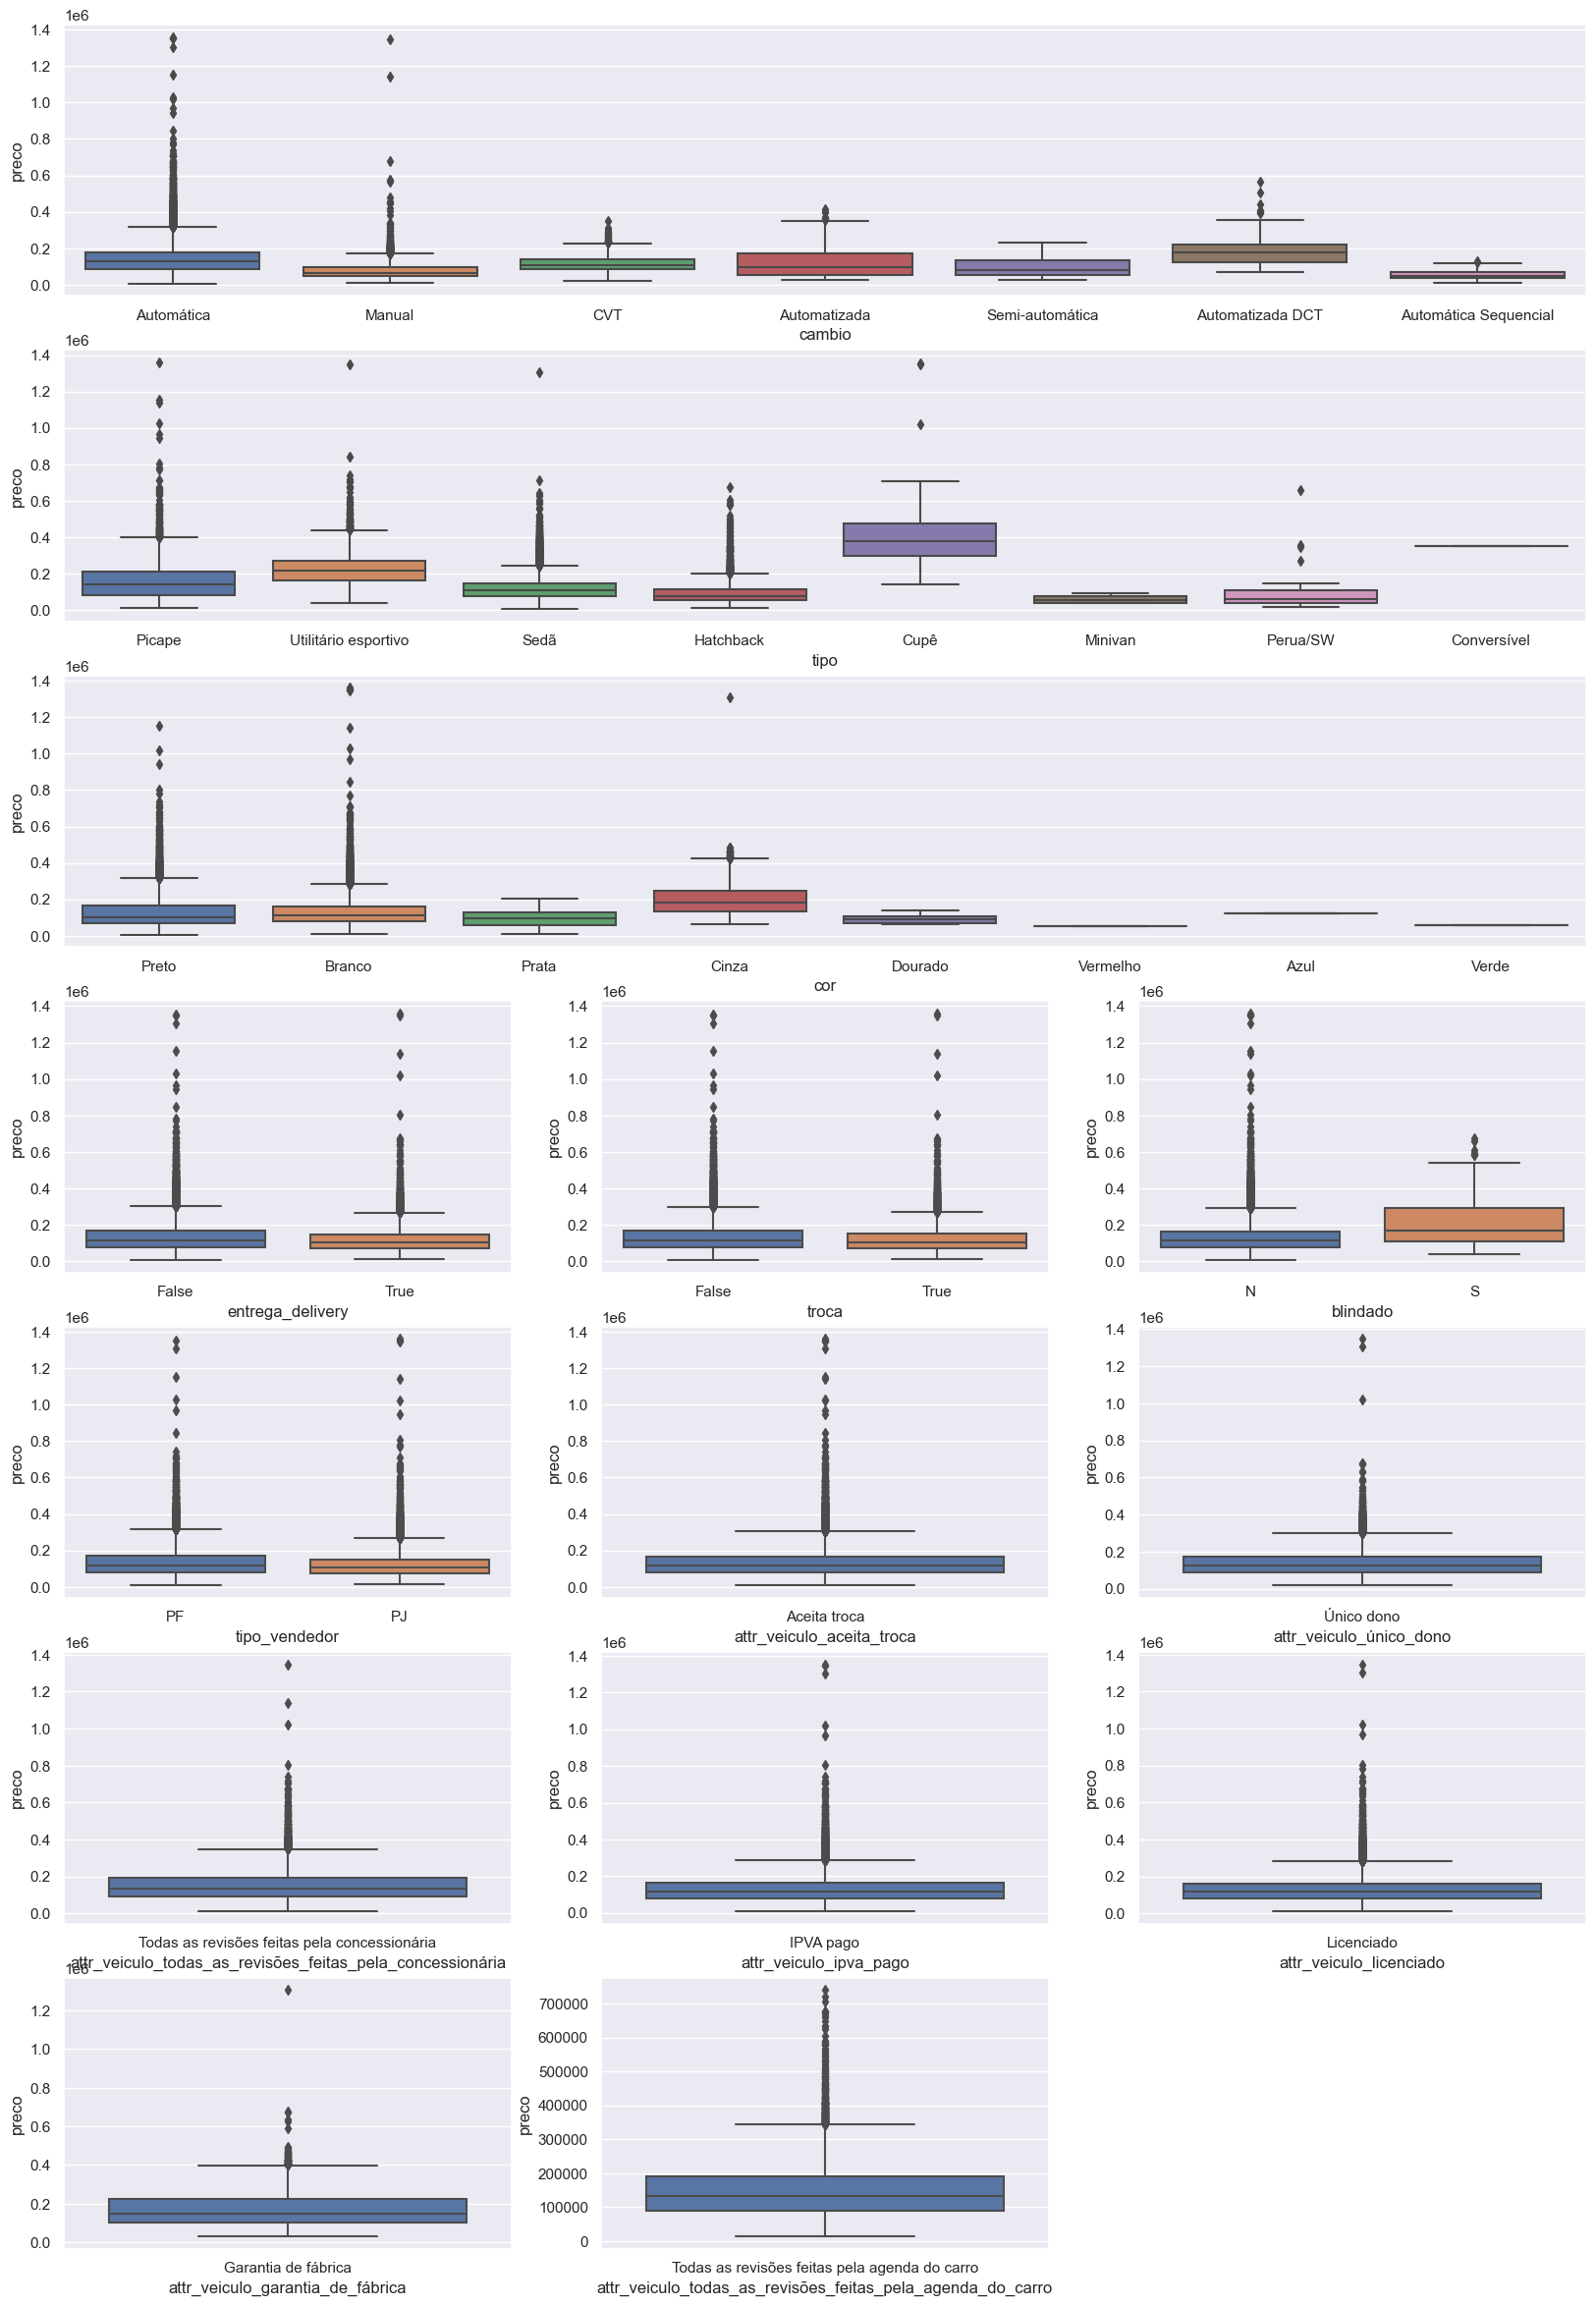

In [16]:
plt.figure(figsize=(20,30))
plt.subplot(7,3,(1,3))
sns.boxplot(x='cambio',y='preco',data=df1)
plt.subplot(7,3,(4,6))
sns.boxplot(x='tipo',y='preco',data=df1)
plt.subplot(7,3,(7,9))
sns.boxplot(x='cor',y='preco',data=df1)
plt.subplot(7,3,10)
sns.boxplot(x='entrega_delivery',y='preco',data=df1)
plt.subplot(7,3,11)
sns.boxplot(x='troca',y='preco',data=df1)
plt.subplot(7,3,12)
sns.boxplot(x='blindado',y='preco',data=df1)
plt.subplot(7,3,13)
sns.boxplot(x='tipo_vendedor',y='preco',data=df1)
plt.subplot(7,3,14)
sns.boxplot(x='attr_veiculo_aceita_troca',y='preco',data=df1)
plt.subplot(7,3,15)
sns.boxplot(x='attr_veiculo_único_dono',y='preco',data=df1)
plt.subplot(7,3,16)
sns.boxplot(x='attr_veiculo_todas_as_revisões_feitas_pela_concessionária',y='preco',data=df1)
plt.subplot(7,3,17)
sns.boxplot(x='attr_veiculo_ipva_pago',y='preco',data=df1)
plt.subplot(7,3,18)
sns.boxplot(x='attr_veiculo_licenciado',y='preco',data=df1)
plt.subplot(7,3,19)
sns.boxplot(x='attr_veiculo_garantia_de_fábrica',y='preco',data=df1)
plt.subplot(7,3,20)
sns.boxplot(x='attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',y='preco',data=df1)

# 2.0. FEATURE ENGINEERING

In [17]:
df2 = df1.copy()

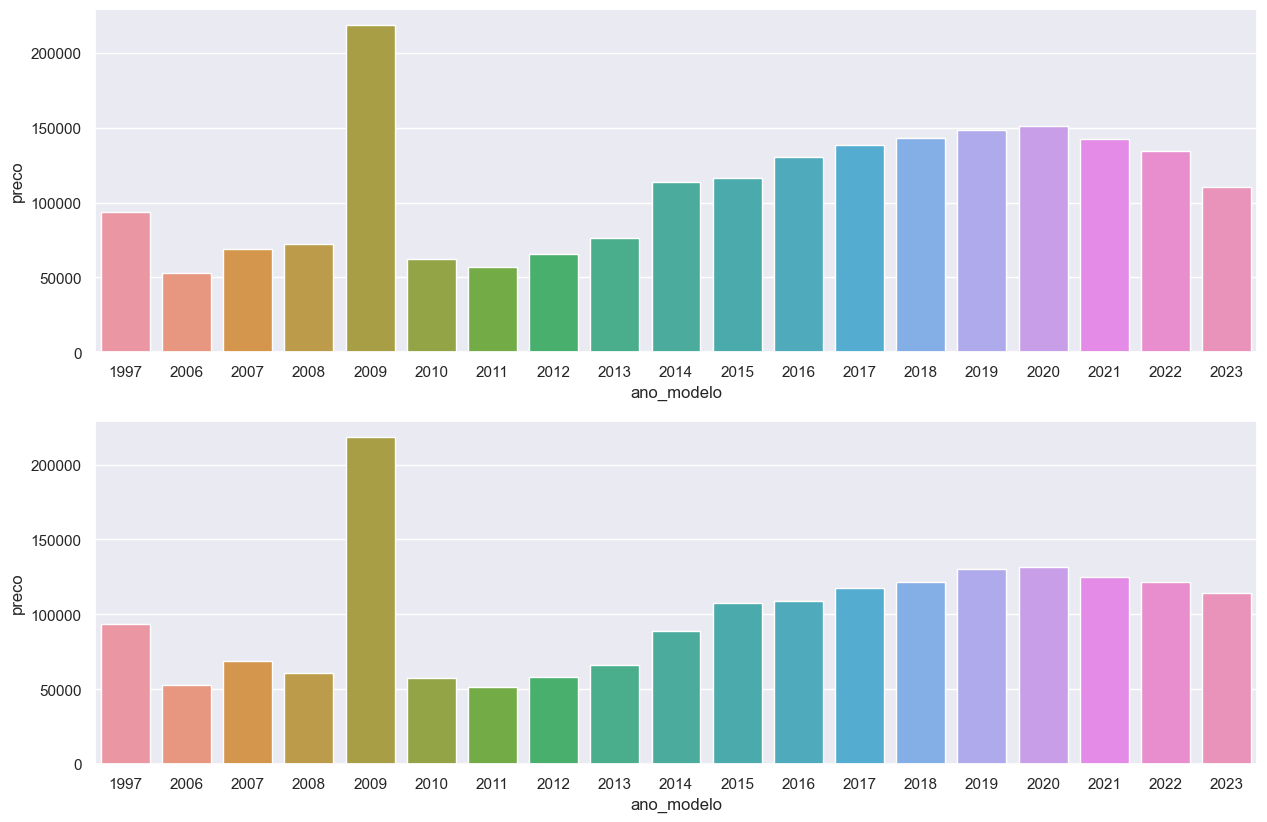

In [18]:
analise_bivariada(df1,'ano_modelo')

In [19]:
df1[df1['ano_modelo']==2009]

,id,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,odometro,cambio,num_portas,...,elegivel_revisao,attr_veiculo_aceita_troca,attr_veiculo_único_dono,attr_veiculo_todas_as_revisões_feitas_pela_concessionária,attr_veiculo_ipva_pago,attr_veiculo_licenciado,attr_veiculo_garantia_de_fábrica,attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro,attr_veiculo_alienado,preco
21412,79259688458176132122276683272499439805,8,KIA,BONGO,2.5 K-2500 4X2 CS TURBO DIESEL 2P MANUAL,2004,2009,381728,Manual,2,...,False,Aceita troca,NaN,NaN,IPVA pago,Licenciado,NaN,NaN,nan,162013.510185
34253,148837369531942189561452244998278325168,8,AUDI,TTS,2.0 TFSI COUPÉ 16V GASOLINA 2P S-TRONIC,1997,2009,31432,Automática,2,...,False,Aceita troca,NaN,NaN,IPVA pago,Licenciado,NaN,NaN,nan,274590.439706


In [20]:
df1[df1['ano_de_fabricacao']==1997]

,id,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,odometro,cambio,num_portas,...,elegivel_revisao,attr_veiculo_aceita_troca,attr_veiculo_único_dono,attr_veiculo_todas_as_revisões_feitas_pela_concessionária,attr_veiculo_ipva_pago,attr_veiculo_licenciado,attr_veiculo_garantia_de_fábrica,attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro,attr_veiculo_alienado,preco
678,116755841525885590326777529894122099215,8,VOLKSWAGEN,TIGUAN,2.0 TSI 16V TURBO GASOLINA 4P TIPTRONIC,1997,2011,99435,Automática,4,...,False,Aceita troca,NaN,NaN,NaN,NaN,NaN,NaN,nan,77459.261812
685,241185348522488236728187010712418973132,15,MERCEDES-BENZ,C 200 K,1.8 AVANTGARDE KOMPRESSOR GASOLINA 4P AUTOMÁTICO,1997,2011,166929,Automática,4,...,False,Aceita troca,NaN,NaN,NaN,NaN,NaN,NaN,nan,7258.159943
973,218593934653040186798445756424523753087,8,DODGE,DAKOTA,3.9 SPORT 4X2 CE V6 12V GASOLINA 2P MANUAL,1997,2013,187800,Manual,4,...,False,Aceita troca,NaN,NaN,IPVA pago,Licenciado,NaN,NaN,nan,97392.819366
1414,236144994903993929810641760968275810033,16,MITSUBISHI,PAJERO TR4,2.0 4X4 16V FLEX 4P MANUAL,1997,2012,111658,Manual,4,...,False,Aceita troca,NaN,NaN,NaN,Licenciado,NaN,NaN,nan,45905.933054
2116,335836811925443509663285340777577079103,14,FIAT,IDEA,1.4 MPI ELX 8V FLEX 4P MANUAL,1997,2011,97449,Manual,4,...,False,Aceita troca,NaN,NaN,IPVA pago,Licenciado,NaN,NaN,nan,41690.939379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37717,314853644466243218944639772136277456280,15,FIAT,IDEA,1.4 MPI FIRE ELX 8V FLEX 4P MANUAL,1997,2010,167912,Manual,4,...,False,Aceita troca,NaN,NaN,NaN,NaN,NaN,NaN,nan,23859.910790
37961,161179070508777590396962848174175701131,8,LAND ROVER,DISCOVERY 3,2.7 HSE 4X4 V6 24V TURBO DIESEL 4P AUTOMÁTICO,1997,2013,130915,Automática,4,...,False,Aceita troca,NaN,Todas as revisões feitas pela concessionária,IPVA pago,Licenciado,NaN,Todas as revisões feitas pela agenda do carro,nan,45005.144901
38326,70256451100091208086789204889323468216,8,MITSUBISHI,PAJERO SPORT,2.5 HPE 4X4 8V TURBO INTERCOOLER DIESEL 4P AUT...,1997,2012,130267,Automática,4,...,False,Aceita troca,NaN,NaN,IPVA pago,Licenciado,NaN,NaN,nan,86008.209691
38853,39297285794073692775892995660774018058,16,FIAT,STRADA,1.8 MPI ADVENTURE CD 16V FLEX 2P MANUAL,1997,2012,67137,Manual,2,...,False,Aceita troca,NaN,NaN,IPVA pago,Licenciado,NaN,NaN,nan,85974.545496


## 2.1. Mapa Mental de Hipóteses

## 2.2. Criação de Hipóteses

In [21]:
df2['odometro'].max()

390065

## 2.3. Lista de Hipóteses

In [22]:
df2[df2["ano_de_fabricacao"] == 1985]

,id,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,odometro,cambio,num_portas,...,elegivel_revisao,attr_veiculo_aceita_troca,attr_veiculo_único_dono,attr_veiculo_todas_as_revisões_feitas_pela_concessionária,attr_veiculo_ipva_pago,attr_veiculo_licenciado,attr_veiculo_garantia_de_fábrica,attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro,attr_veiculo_alienado,preco
7530,317058348344627599337634039380150700902,8,VOLKSWAGEN,GOL,1.6 MI POWER 8V FLEX 4P MANUAL G.III,1985,2013,192182,Manual,4,...,False,NaN,NaN,NaN,IPVA pago,Licenciado,NaN,NaN,nan,22520.067767


## 2.4. Feature Engineering

In [23]:
# ano de fabricacao one hot
bin1 = [1985, 2000]
bin2 = [2000, 2005]
bin3 = [2005, 2010]
bin4 = [2010, 2015]
bin5 = [2015, 2020]
bin6 = [2020, 2025]
bins = [bin1, bin2, bin3, bin4, bin5, bin6]

year_bins = []

for i in range(df2.shape[0]):
    tmp = [0 for i in range(len(bins))]
    ye = df2['ano_de_fabricacao'][i]
    for j in range(len(bins)):
        if ye >= bins[j][0] and ye < bins[j][1]:
            tmp[j] = 1
    year_bins.append(tmp)
year_bins = np.asarray(year_bins)
new_df = pd.DataFrame(year_bins, columns=['Year_Bin'+str(i+1) for i in range(len(bins))])
df2 = pd.concat( [df2, new_df], axis=1 )
# df2 = df2.drop(columns=['ano_de_fabricacao'])

# # kilometragem one hot

# cbin1 = [7000, 20000]
# cbin2 = [20000, 40000]
# cbin3 = [40000, 80000]
# cbin4 = [80000, 100000]
# cbin5 = [100000, 200000]
# cbin6 = [200000, 500000]
# cbin7 = [500000, 1000000]
# cbins = [bin1, bin2, bin3, bin4, bin5, bin7]

# cyear_bins = []

# for i in range(df2.shape[0]):
#     tmp = [0 for i in range(len(cbins))]
#     ye = df2['ano_de_fabricacao'][i]
#     for j in range(len(cbins)):
#         if ye >= cbins[j][0] and ye < cbins[j][1]:
#             tmp[j] = 1
#     year_bins.append(tmp)
# year_bins = np.asarray(cyear_bins)
# new_df = pd.DataFrame(cyear_bins, columns=['Year_Bin'+str(i+1) for i in range(len(cbins))])
# df2 = pd.concat( [df2, new_df], axis=1 )
# df2 = df2.drop(columns=['ano_de_fabricacao'])

# 3.0. FILTRAGEM DE VARIÁVEIS

In [24]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [25]:
# substituindo ano de fabricacao caso a diferença para o ano modelo seja superior a 1 ano
df3['dif_ano'] = df3.apply(lambda x: x['ano_modelo'] - x['ano_de_fabricacao'], axis=1)
df3[df3['dif_ano'] > 1].count()

df3['ano_de_fabricacao'] = df3.apply(lambda x: (x['ano_modelo']-1) if x['dif_ano'] > 1 else x['ano_de_fabricacao'], axis=1)

## 3.2. Seleção das Colunas

In [26]:
df3 = df3.drop( columns=['elegivel_revisao','attr_veiculo_alienado', 'dif_ano'])

# 4.0. EDA

In [27]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

f:\SamuelOliveiraAlvesd\Anaconda3\envs\Health_Insurance_Cross_Sell\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
f:\SamuelOliveiraAlvesd\Anaconda3\envs\Health_Insurance_Cross_Sell\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


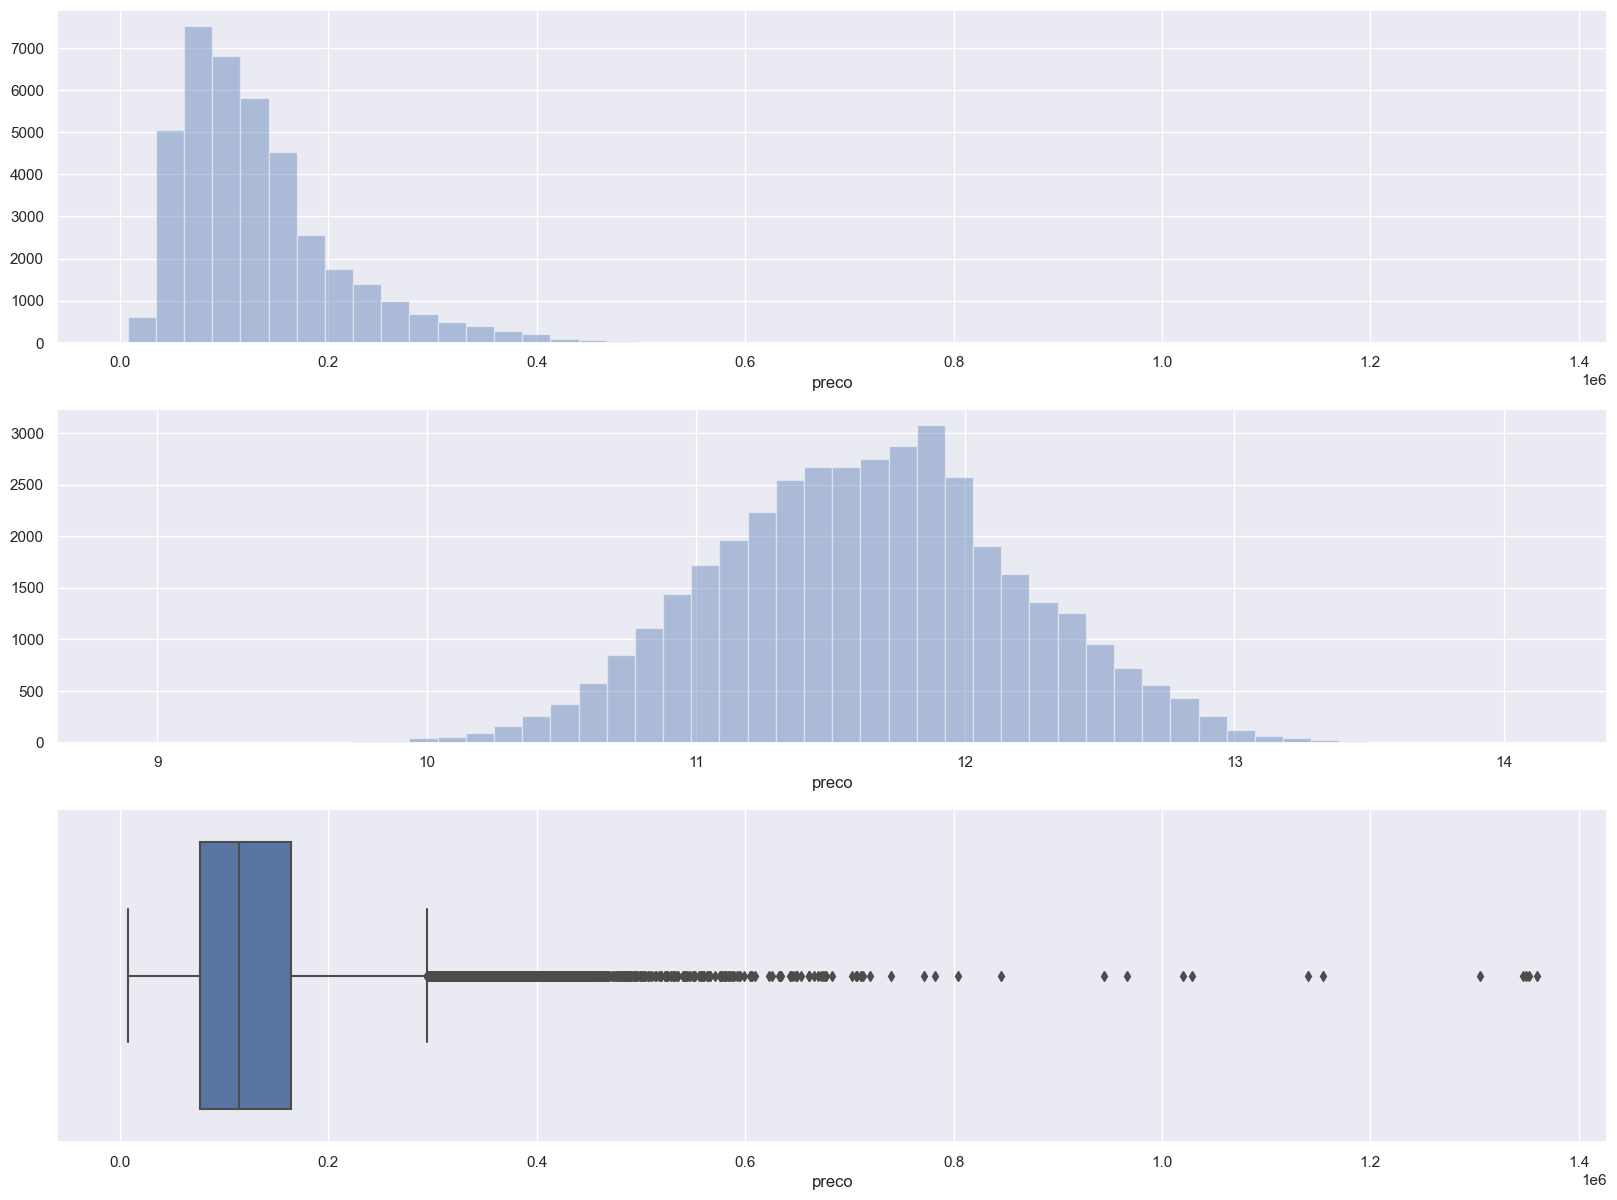

In [28]:
plt.figure(figsize=(20,15))
plt.subplot(3,1,1)
sns.distplot(df4['preco'], kde=False);
# transformação log
plt.subplot(3,1,2)
sns.distplot(np.log(df4['preco']), kde=False);
plt.subplot(3,1,3)
sns.boxplot(df4['preco']);

### 4.1.1. Numerical Variable

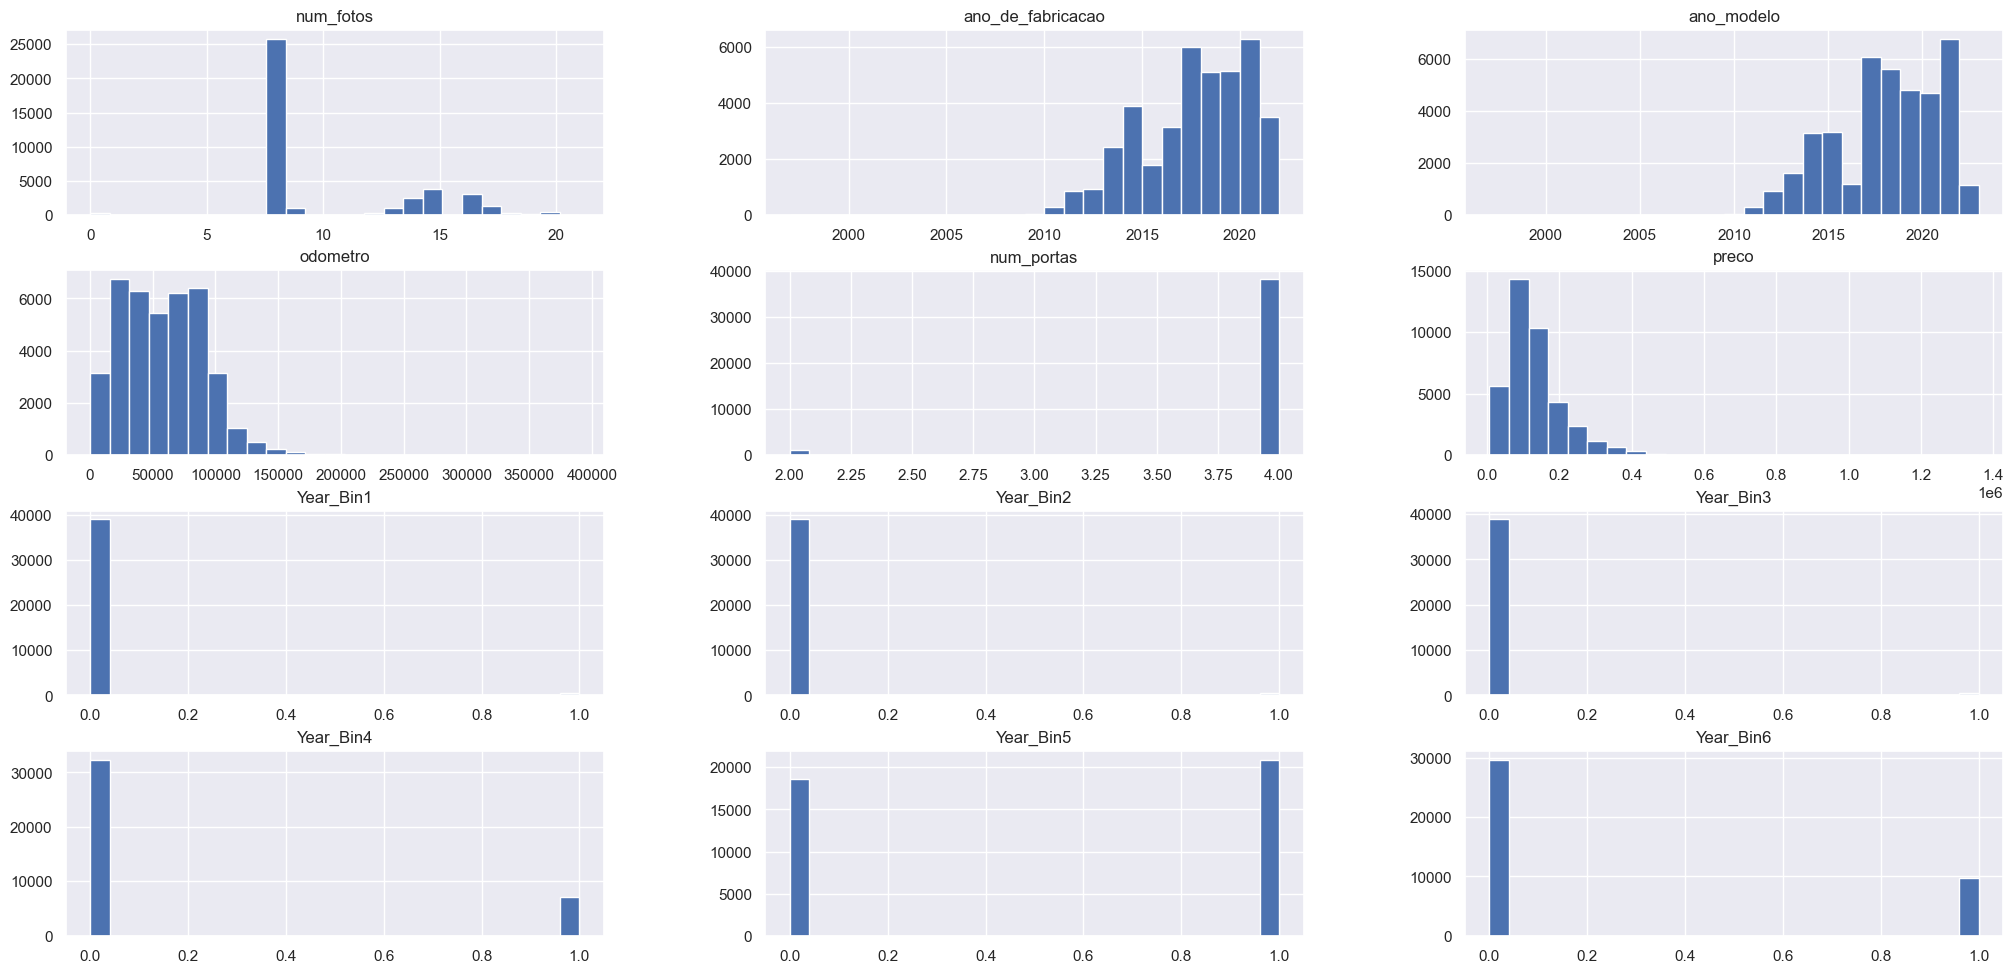

In [29]:
num_attributes = df4.select_dtypes(include='number')
num_attributes.hist(bins=25);

In [30]:
print(df4[df4['ano_de_fabricacao']<2012].shape)
print(df4[df4['ano_modelo']<2012].shape)

(1146, 33)
(332, 33)


In [31]:
df4[df4['ano_de_fabricacao'] == 1988]

,id,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,odometro,cambio,num_portas,...,attr_veiculo_licenciado,attr_veiculo_garantia_de_fábrica,attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro,preco,Year_Bin1,Year_Bin2,Year_Bin3,Year_Bin4,Year_Bin5,Year_Bin6


### 4.1.1Categorical Variable

In [32]:
cat_attributes = df4.select_dtypes(exclude='number')
cat_attributes.columns

Index(['id', 'marca', 'modelo', 'versao', 'cambio', 'tipo', 'blindado', 'cor',
       'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor', 'tipo_anuncio',
       'entrega_delivery', 'troca', 'attr_veiculo_aceita_troca',
       'attr_veiculo_único_dono',
       'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fábrica',
       'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'],
      dtype='object')

## 4.2. Analise Bivariada

In [33]:
df4['estado_vendedor'].unique()

array(['São Paulo (SP)', 'Rio Grande do Sul (RS)', 'Minas Gerais (MG)',
       'Paraná (PR)', 'Rio de Janeiro (RJ)', 'Maranhão (MA)',
       'Santa Catarina (SC)', 'Alagoas (AL)', 'Bahia (BA)', 'Goiás (GO)',
       'Rio Grande do Norte (RN)', 'Pernambuco (PE)', 'Mato Grosso (MT)',
       'Pará (PA)', 'Ceará (CE)', 'Amazonas (AM)', 'Espírito Santo (ES)',
       'Rondônia (RO)', 'Paraíba (PB)', 'Tocantins (TO)', 'Acre (AC)',
       'Sergipe (SE)', 'Mato Grosso do Sul (MS)', 'Roraima (RR)',
       'Piauí (PI)'], dtype=object)

In [34]:
#df4['estado_vendedor']=df4['estado_vendedor'].apply(lambda x: 'SP' if x='São Paulo (SP)')# else 
                                        #'RS' if x='Rio Grande do Sul (RS)' else 
                                        #'MG' if x='Minas Gerais (MG)'  else
                                        #'PR' if x='Paraná (PR)' else
                                        #'RJ' if x='Rio de Janeiro (RJ)' else
                                        #'MA' if x='Maranhão (MA)' else
                                        #'SC' if x='Santa Catarina (SC)' else
                                        #'AL' if x='Alagoas (AL)' else
                                        #'BA' if x='Bahia (BA)' else
                                        #'GO' if x='Goiás (GO)' else
                                        #'RN' if x='Rio Grande do Norte (RN)' else
                                        #'PE' if x='Pernambuco (PE)' else
                                        #'MT' if x='Mato Grosso (MT)' else
                                        #'PA' if x='Pará (PA)' else
                                        #'CE' if x='Ceará (CE)' else
                                        #'AM' if x='Amazonas (AM)' else
                                        #'ES' if x='Espírito Santo (ES)'else
                                        #'RO' if x='Rondônia (RO)' else
                                        #'PB' if x='Paraíba (PB)' else
                                        #'TO' if x='Tocantins (TO)' else
                                        #'AC' if x='Acre (AC)'else
                                        #'SE' if x='Sergipe (SE)' else
                                        #'MS' if x='Mato Grosso do Sul (MS)' else
                                        #'RR' if x='Roraima (RR)'else
                                        #'PI' if x='Piauí (PI)')


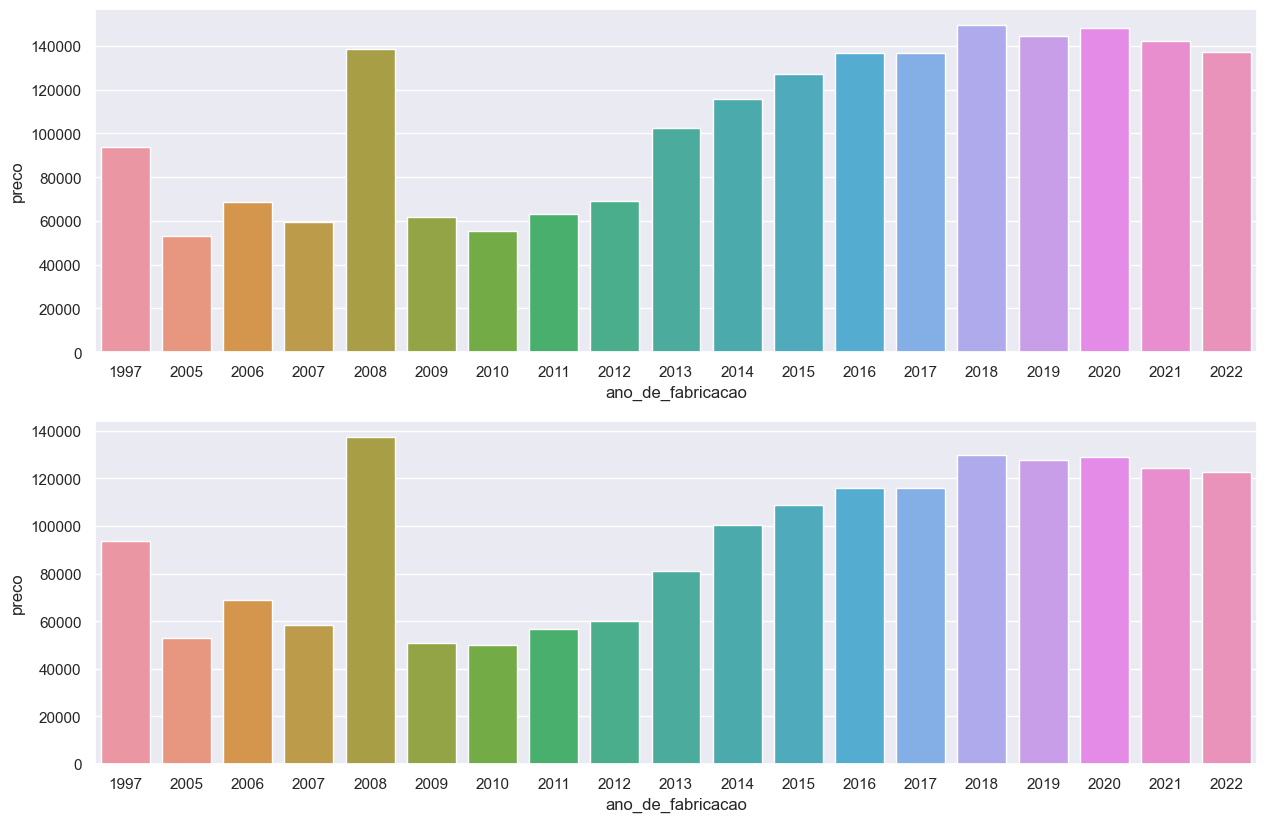

In [35]:
analise_bivariada(df4,'ano_de_fabricacao')

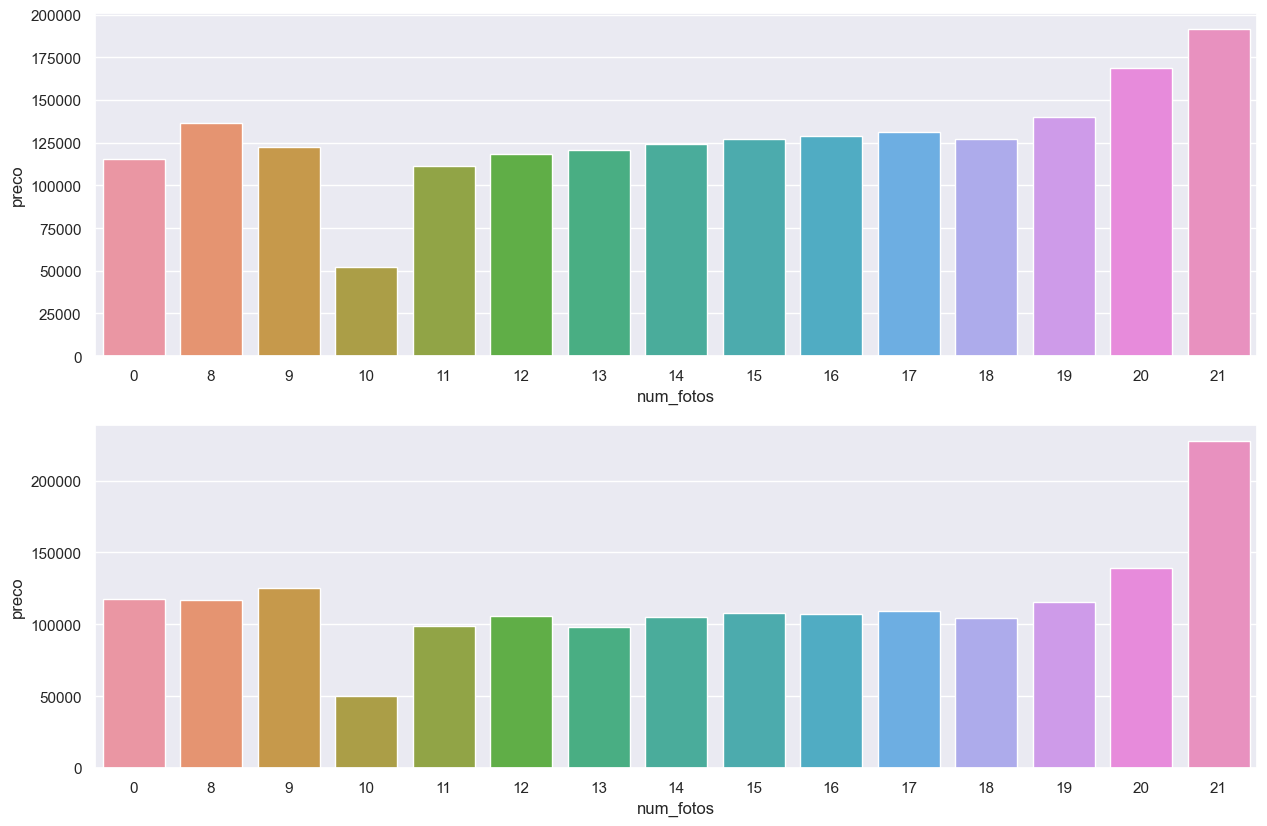

In [36]:
analise_bivariada(df4,'num_fotos')

## 4.3. Analise Multivariada

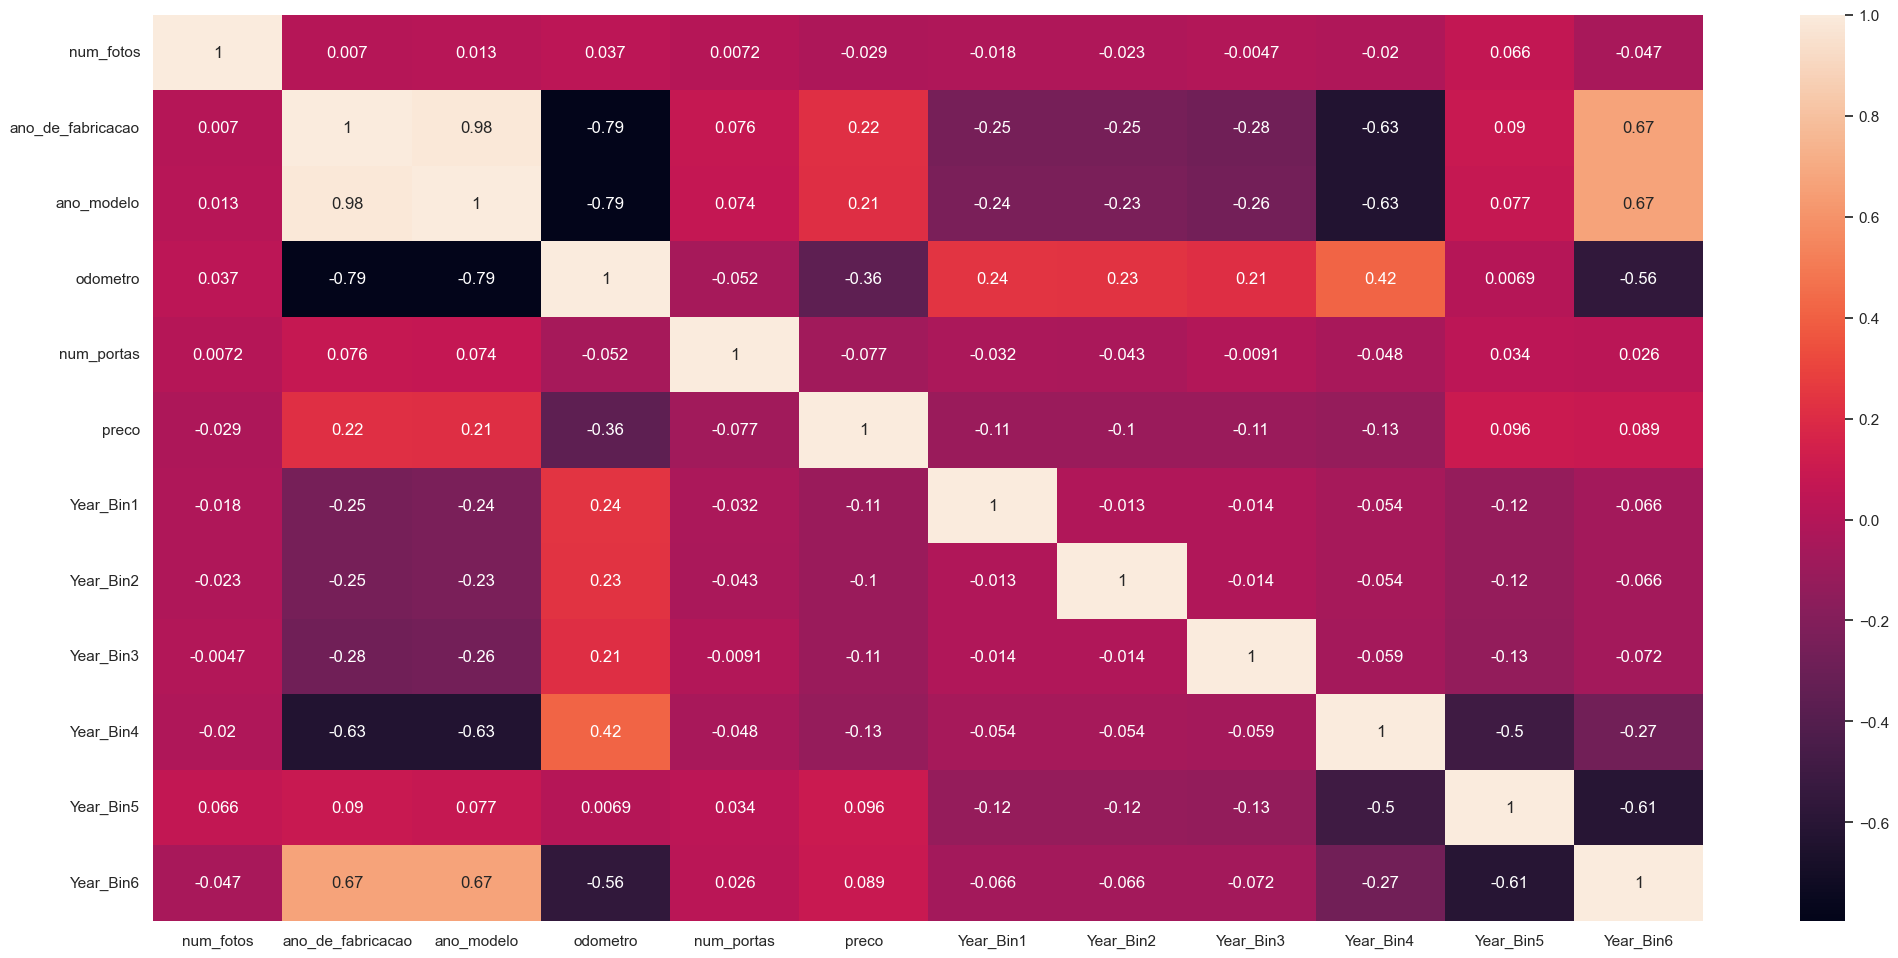

In [37]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

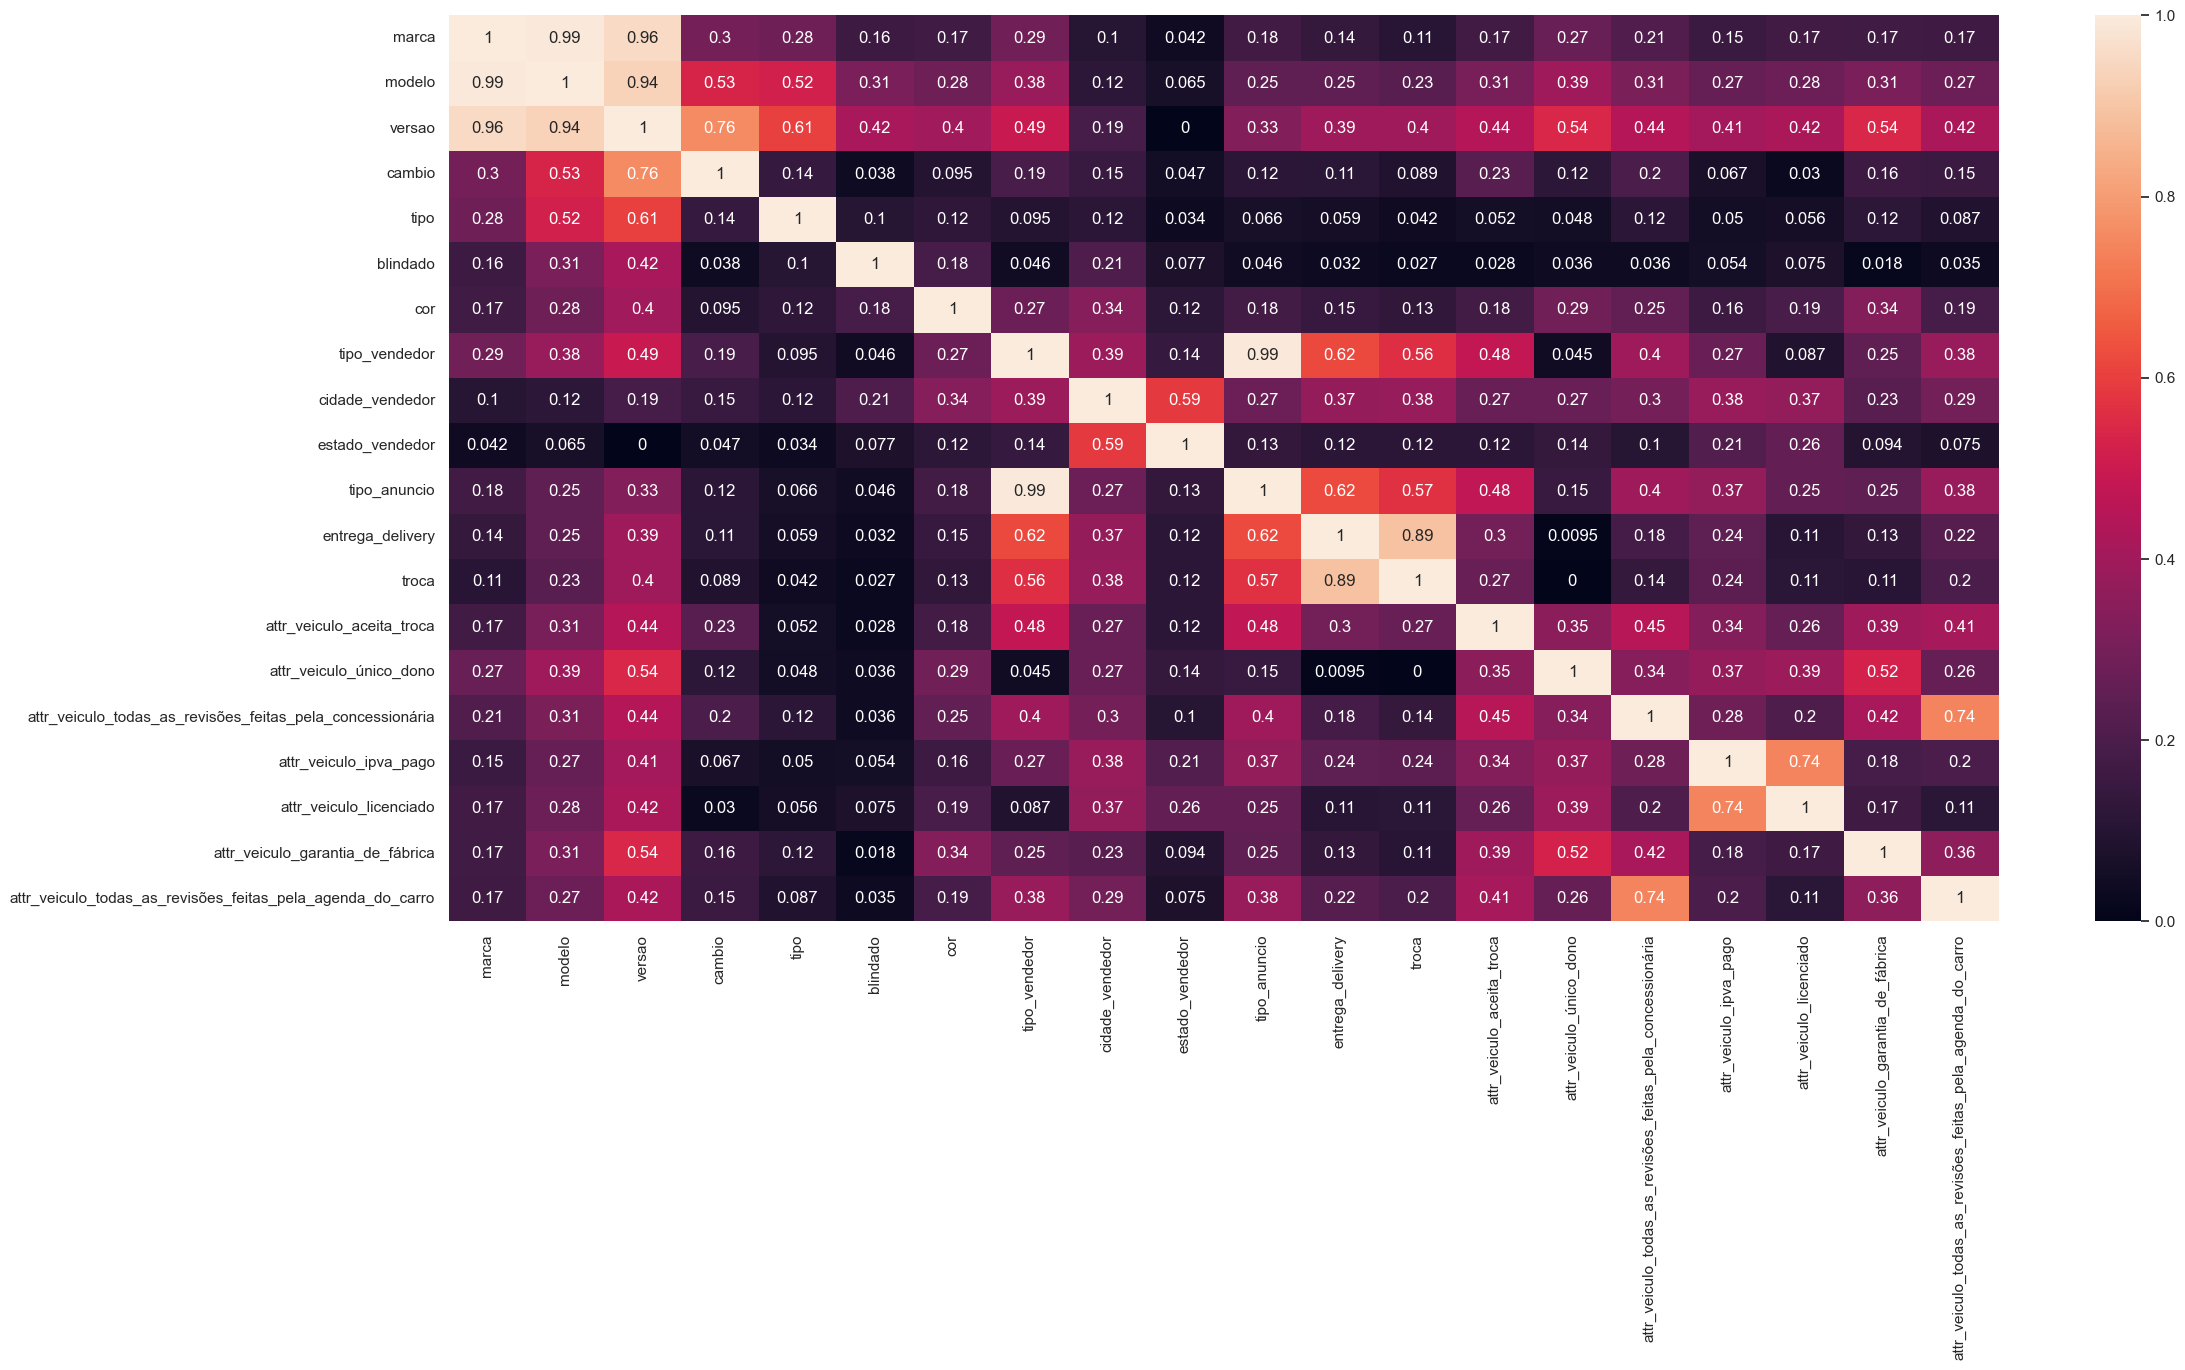

In [38]:
plotcor = pycorrcat.corr_matrix(cat_attributes, ['marca', 'modelo', 'versao', 'cambio', 'tipo', 'blindado', 'cor',
       'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor', 'tipo_anuncio',
       'entrega_delivery', 'troca', 'attr_veiculo_aceita_troca',
       'attr_veiculo_único_dono',
       'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fábrica',
       'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'])
sns.heatmap(plotcor, annot=True);

# 5.0. DATA PREPARATION

In [39]:
df5 = df4.copy()

## 5.1. Encoding

In [40]:
df5.dtypes

id                                                             object
num_fotos                                                       int32
marca                                                          object
modelo                                                         object
versao                                                         object
ano_de_fabricacao                                               int64
ano_modelo                                                      int32
odometro                                                        int32
cambio                                                         object
num_portas                                                      int64
tipo                                                           object
blindado                                                       object
cor                                                            object
tipo_vendedor                                                  object
cidade_vendedor     

In [41]:
df5['motor'] = df5.apply(lambda x: x['versao'][:3], axis=1)
df5['motor'] = df5['motor'].replace(['B12', 'BEV', 'ELÉ', 'TUR', 'P8 ', '4S ', 'BEV', '90 ', 'EV ', 'Z.E'], 0)
df5['motor'] = df5['motor'].astype('float64')
df5['motor'].unique()

array([2. , 1.8, 1. , 1.6, 1.4, 1.3, 3.2, 1.5, 2.2, 3.3, 2.8, 3. , 2.7,
       5. , 6.7, 4.6, 2.3, 2.5, 2.4, 6.2, 2.9, 0. , 4.4, 3.6, 3.5, 4. ,
       2.1, 3.8, 1.2, 4.8, 3.9, 4.7, 4.2, 4.3, 5.5, 5.2, 1.7, 4.5, 4.1,
       3.7, 5.7, 0.6, 1.1, 5.9, 4.9, 6.3, 1.9])

In [42]:
# colunas pra dropar: id
df5 = df5.drop( columns=['id'] )

# binario (0/1): blindado, troca, elegivel_revisao, attr_veiculo_aceita_troca, attr_veiculo_único_dono,
# attr_veiculo_todas_as_revisões_feitas_pela_concessionária, attr_veiculo_ipva_pago, attr_veiculo_licenciado
# attr_veiculo_ipva_pago, attr_veiculo_licenciado, attr_veiculo_garantia_de_fábrica
df5['blindado'] = df5['blindado'].apply( lambda x: 0 if x == "false" else 1 if x=="true" else 0 )
df5['troca'] = df5['troca'].apply( lambda x: 0 if x == "false" else 1 if x=="true" else 0 )
#df5['elegivel_revisao'] = df5['elegivel_revisao'].apply( lambda x: 0 if x == "false" else 1 if x=="true" else 0 )
df5['entrega_delivery'] = df5['entrega_delivery'].apply( lambda x: 0 if x == "false" else 1 if x=="true" else 0 )
df5['attr_veiculo_aceita_troca'] = df5['attr_veiculo_aceita_troca'].apply( lambda x: 0 if x == "Aceita troca" else 0 )
df5['attr_veiculo_único_dono'] = df5['attr_veiculo_único_dono'].apply( lambda x: 0 if x == "Único dono" else 0 )
df5['attr_veiculo_todas_as_revisões_feitas_pela_concessionária'] = df5['attr_veiculo_todas_as_revisões_feitas_pela_concessionária'].apply( lambda x: 0 if x == "Todas as revisões feitas pela concessionária" else 0 )
df5['attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'] = df5['attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'].apply( lambda x: 0 if x == "Todas as revisões feitas pela agenda do carro" else 0 )
df5['attr_veiculo_ipva_pago'] = df5['attr_veiculo_ipva_pago'].apply( lambda x: 0 if x == "IPVA pago" else 0 )
df5['attr_veiculo_licenciado'] = df5['attr_veiculo_licenciado'].apply( lambda x: 0 if x == "Licenciado" else 0 )
df5['attr_veiculo_garantia_de_fábrica'] = df5['attr_veiculo_garantia_de_fábrica'].apply( lambda x: 0 if x == "Garantia de fábrica" else 0 )
#df5 = df5.drop( columns = ['attr_veiculo_aceita_troca','attr_veiculo_único_dono','attr_veiculo_todas_as_revisões_feitas_pela_concessionária','attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro','attr_veiculo_ipva_pago','attr_veiculo_licenciado','attr_veiculo_garantia_de_fábrica'] )
#df5 = df5.drop( columns =['attr_veiculo_alienado'] )
# dummies: marca, cambio, tipo, tipo_vendedor
df5 = pd.get_dummies( df5, columns=['cambio', 'tipo_anuncio', 'tipo_vendedor'] )

# frequency encoder/label encoder: modelo, versao
# fe_modelo = df5.groupby('modelo').size() / len(df5)
# df5.loc[:,'modelo'] = df5['modelo'].map(fe_modelo)

# fe_versao = df5.groupby('versao').size() / len(df5)
# df5.loc[:,'versao'] = df5['versao'].map(fe_versao)
le = LabelEncoder()
df5['modelo'] = le.fit_transform(df5['modelo'])
df5['versao'] = le.fit_transform(df5['versao'])

# fe_marca = df5.groupby('marca').size() / len(df5)
# df5.loc[:,'marca'] = df5['marca'].map(fe_marca)

# fe_cor = df5.groupby('cor').size() / len(df5)
# df5.loc[:,'cor'] = df5['cor'].map(fe_cor)

# fe_tipo = df5.groupby('tipo').size() / len(df5)
# df5.loc[:,'tipo'] = df5['tipo'].map(fe_tipo)

#fe_cambio = df5.groupby('cambio').size() / len(df5)
#df5.loc[:, 'cambio'] = df5['cambio'].map(fe_cambio)

# label encoder
# le = LabelEncoder()

#df5['tipo_anuncio'] = le.fit_transform(df5['tipo_anuncio'])

df5['marca'] = le.fit_transform(df5['marca'])
df5['cor'] = le.fit_transform(df5['cor'])
df5['tipo'] = le.fit_transform(df5['tipo'])

fe_cidade_vendedor = df5.groupby('cidade_vendedor').size() / len(df5)
df5.loc[:,'cidade_vendedor'] = df5['cidade_vendedor'].map(fe_cidade_vendedor)

fe_estado_vendedor = df5.groupby('estado_vendedor').size() / len(df5)
df5.loc[:,'estado_vendedor'] = df5['estado_vendedor'].map(fe_estado_vendedor)

## 5.2. Normalização

## 5.3. Rescaling

In [43]:
df5['versao'].value_counts()

425     1825
930     1355
1344    1007
21       624
1157     567
        ... 
1511       1
259        1
1652       1
1167       1
54         1
Name: versao, Length: 2058, dtype: int64

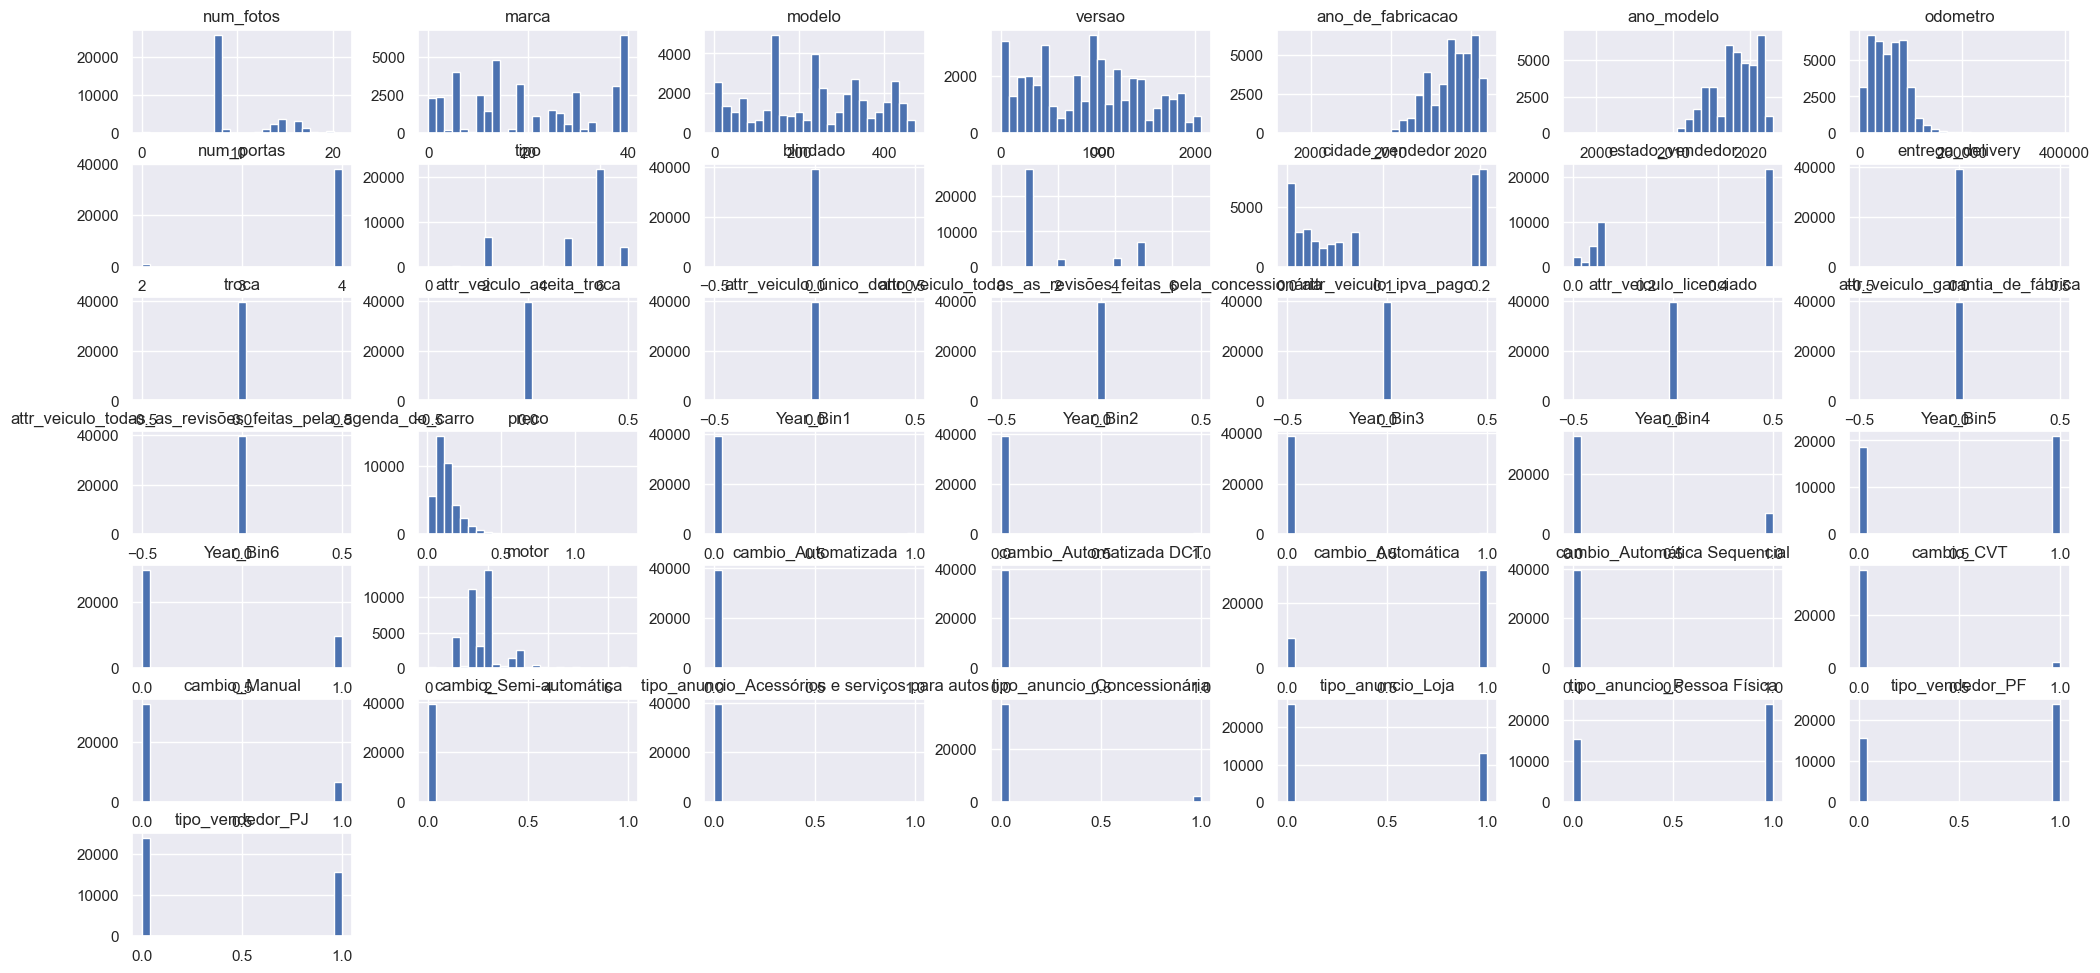

In [44]:
num_attributes = df5.select_dtypes(include='number')
num_attributes.hist(bins=25);

rs = RobustScaler()
mms = MinMaxScaler()

# num_fotos - rescaling
df5['num_fotos'] = mms.fit_transform(df5[['num_fotos']].values)

# ano_de_fabricacao - rescaling
df5['ano_de_fabricacao'] = rs.fit_transform(df5[['ano_de_fabricacao']].values)

# ano_modelo - rescaling
df5['ano_modelo'] = rs.fit_transform(df5[['ano_modelo']].values)

# odometro - rescaling
df5['odometro'] = rs.fit_transform(df5[['odometro']].values)

## 5.4. Transformação

In [45]:
df5['preco'] = np.log1p(df5['preco'])

# 6.0. FEATURE SELECTION

In [46]:
df6 = df5.copy()

In [47]:
df6.isna().sum()

num_fotos                                                     0
marca                                                         0
modelo                                                        0
versao                                                        0
ano_de_fabricacao                                             0
ano_modelo                                                    0
odometro                                                      0
num_portas                                                    0
tipo                                                          0
blindado                                                      0
cor                                                           0
cidade_vendedor                                               0
estado_vendedor                                               0
entrega_delivery                                              0
troca                                                         0
attr_veiculo_aceita_troca               

## 6.1. Manual Selection

## 6.2. Feature Importancia

In [48]:
# model
forest = en.ExtraTreesRegressor( n_estimators=250, random_state=0, n_jobs=-1 )

# training
x_train_fselection = df6.drop(['preco'], axis=1 )
y_train_fselection = df6['preco'].values
forest.fit( x_train_fselection, y_train_fselection )

KeyboardInterrupt: 

Feature Ranking:

                                             feature  importance
0                                             versao    0.175538
0                                      cambio_Manual    0.134670
0                                           odometro    0.116751
0                                              motor    0.076083
0                                               tipo    0.075633
0                                         ano_modelo    0.066896
0                                  ano_de_fabricacao    0.062406
0                                              marca    0.055631
0                                             modelo    0.047040
0                                                cor    0.036704
0                                    cidade_vendedor    0.029947
0                                    estado_vendedor    0.020392
0                                          Year_Bin5    0.017510
0                                          Year_Bin4    0.016677
0      

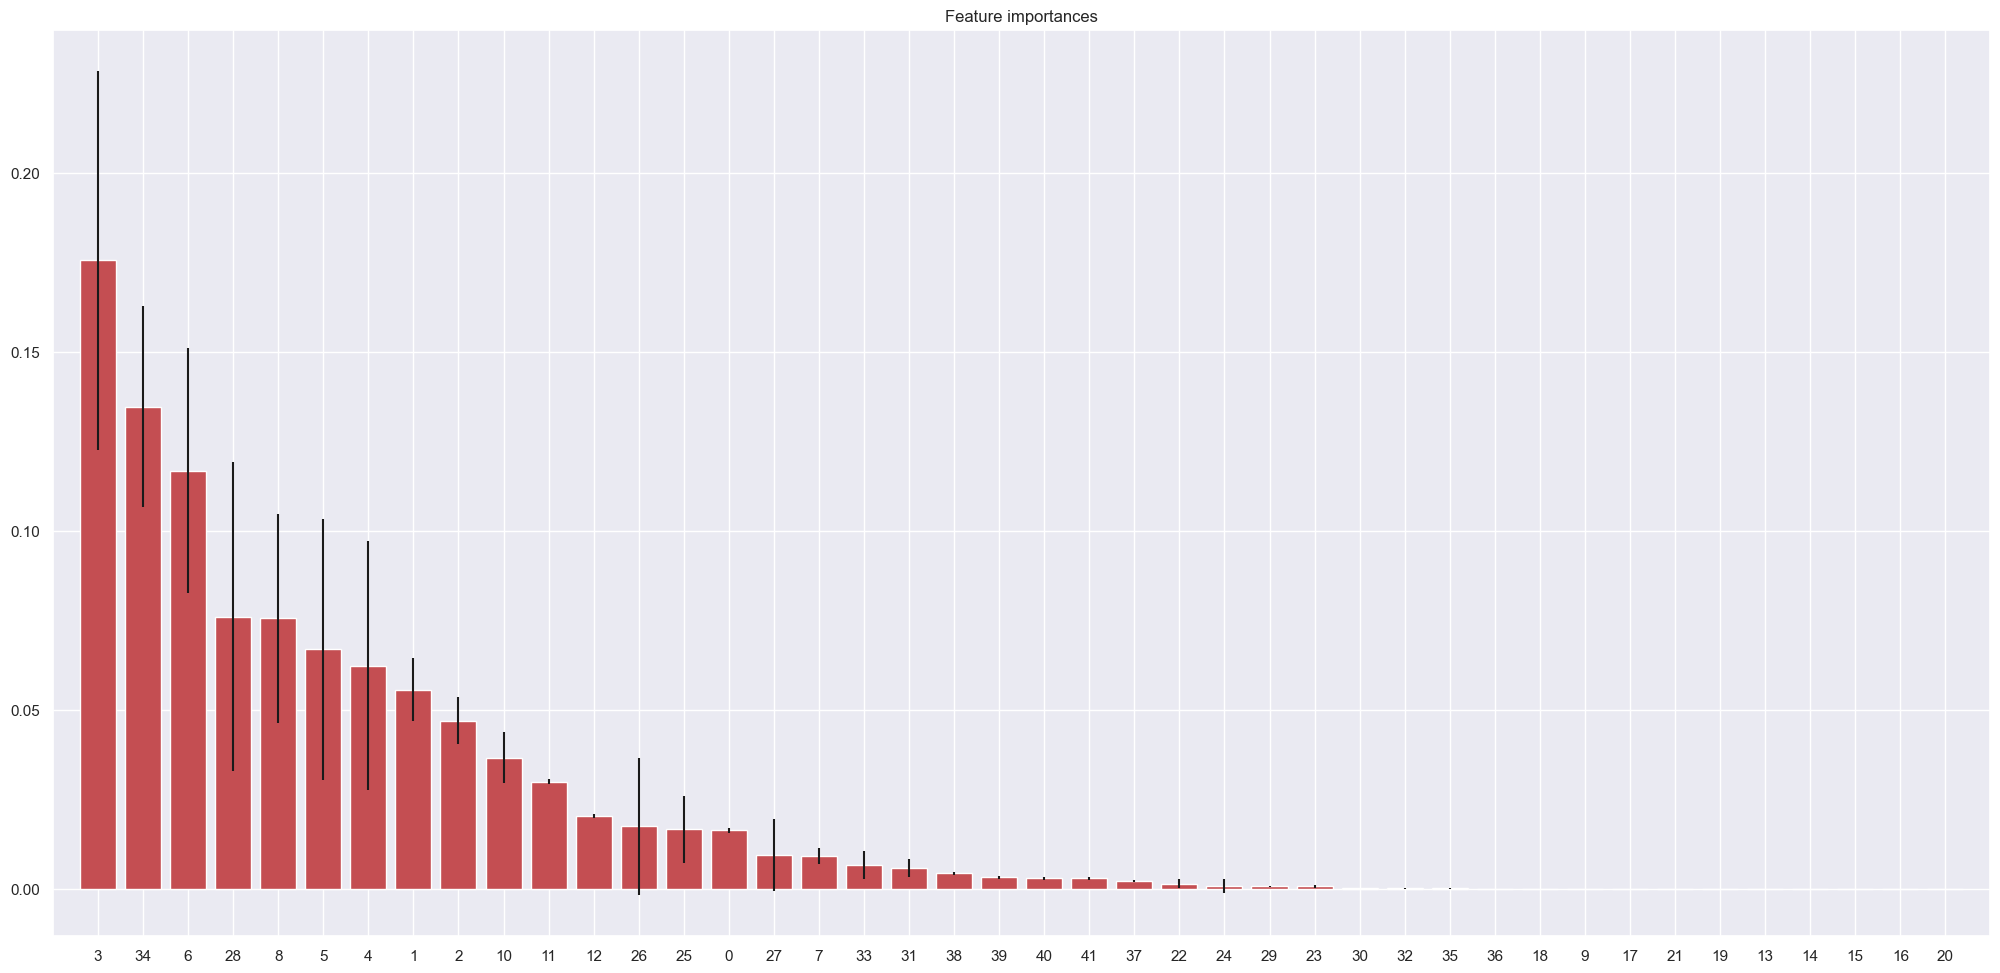

In [ ]:
importances = forest.feature_importances_
std = np.std( [tree.feature_importances_ for tree in forest.estimators_], axis=0 )
indices = np.argsort( importances )[::-1]

# print the feature ranking
df = pd.DataFrame()

print( 'Feature Ranking:\n' )
for i, j in zip( x_train_fselection,forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) ) 

# plot the impurity-based feature importances of the forest
plt.figure()
plt.title( 'Feature importances' )
plt.bar( range( x_train_fselection.shape[1] ), importances[indices], color='r', yerr=std[indices], align='center' )
plt.xticks( range(x_train_fselection.shape[1]), indices )
plt.xlim( [-1, x_train_fselection.shape[1]] )
plt.show()

## 6.3. Boruta Selection

In [49]:
feature_columns = ['versao', 'cambio_Manual', 'odometro', 'tipo', 'ano_modelo', 'ano_de_fabricacao',  'modelo',
            'marca', 'cor', 'cidade_vendedor', 'estado_vendedor', 'num_fotos', 'Year_Bin4', 'Year_Bin5', 'num_portas']


# 7.0. MACHINE LEARNING MODELLING

In [50]:
df7 = df6.copy()

X = df7.drop(columns=["preco"])
X = X[feature_columns]
Y = df7['preco'].copy()

X_train, X_val, y_train, y_val = ms.train_test_split( X, Y, test_size=0.2, random_state=42 )

## 7.1. Linear Regression

In [ ]:
# model training
lr = LinearRegression().fit( X_train, y_train )

# prediction
yhat_lr = lr.predict( X_val )

# performance (error)
lr_results = ml_error( 'Linear Regression', np.expm1( y_val ) , np.expm1( yhat_lr ) )
lr_results

,Model name,MAE,MAPE,RMSE
0,Linear Regression,39733.158327,0.318584,62487.162843


In [ ]:
# model training
lr = LinearRegression().fit( X_train, y_train )

# prediction
yhat_lr = lr.predict( X_val )

# performance (error)
lr_results = ml_error( 'Linear Regression', np.expm1( y_val ) , np.expm1( yhat_lr ) )
lr_results

,Model name,MAE,MAPE,RMSE
0,Linear Regression,40763.422722,0.325195,63812.924403


In [ ]:
y_train.isna().sum()

0

### 7.1.1. Cross Validation

## 7.2. LASSO

### 7.2.1. Cross Validation

## 7.3. Random Forest Regressor

In [ ]:
# model
rf = RandomForestRegressor( n_estimators=150, n_jobs=-1, random_state=42 ).fit( X_train, y_train )

# prediction
yhat_rf = rf.predict( X_val )

# performance
rf_results = ml_error( 'Random Forest Regressor', np.expm1(y_val), np.expm1(yhat_rf) )
rf_results

,Model name,MAE,MAPE,RMSE
0,Random Forest Regressor,27185.655076,0.214886,45873.883147


In [ ]:
# model
rf = RandomForestRegressor( n_estimators=150, n_jobs=-1, random_state=42 ).fit( X_train, y_train )

# prediction
yhat_rf = rf.predict( X_val )

# performance
rf_results = ml_error( 'Random Forest Regressor', np.expm1(y_val), np.expm1(yhat_rf) )
rf_results

,Model name,MAE,MAPE,RMSE
0,Random Forest Regressor,27231.320339,0.215597,45884.560836


### 7.3.1. Cross Validation

## 7.4. Decision Tree Regressor

### 7.4.1. Cross Validation

## 7.5. XGBoost Regressor

In [ ]:
# model
model_xgb = xgb.XGBRegressor( n_estimators=400 ).fit( X_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( X_val )

# performance
model_xgb_results = ml_error( 'XGBoost Regressor',  np.expm1(y_val), np.expm1(yhat_xgb) )
model_xgb_results

f:\SamuelOliveiraAlvesd\Anaconda3\envs\Health_Insurance_Cross_Sell\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,Model name,MAE,MAPE,RMSE
0,XGBoost Regressor,27044.579805,0.211457,45467.535895


In [ ]:
# model
model_xgb = xgb.XGBRegressor( n_estimators=400 ).fit( X_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( X_val )

# performance
model_xgb_results = ml_error( 'XGBoost Regressor',  np.expm1(y_val), np.expm1(yhat_xgb) )
model_xgb_results

f:\SamuelOliveiraAlvesd\Anaconda3\envs\Health_Insurance_Cross_Sell\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,Model name,MAE,MAPE,RMSE
0,XGBoost Regressor,27268.687163,0.213101,45742.308666


### 7.5.1. Cross Validation

## 7.6. LightGBM

In [ ]:
# model
model_lgb = lgb.LGBMRegressor( n_estimators=400).fit( X_train, y_train )

# prediction
yhat_lgb = model_lgb.predict( X_val )

# performance
model_lgb_results = ml_error( 'LightGBM Regressor',  np.expm1(y_val), np.expm1(yhat_lgb) )
model_lgb_results

,Model name,MAE,MAPE,RMSE
0,LightGBM Regressor,26679.496158,0.208391,44959.220651


In [ ]:
# model
model_lgb = lgb.LGBMRegressor( n_estimators=400).fit( X_train, y_train )

# prediction
yhat_lgb = model_lgb.predict( X_val )

# performance
model_lgb_results = ml_error( 'LightGBM Regressor',  np.expm1(y_val), np.expm1(yhat_lgb) )
model_lgb_results

,Model name,MAE,MAPE,RMSE
0,LightGBM Regressor,26621.714666,0.207864,45017.238217


In [ ]:
# best parameters
params = {'n_estimators' : 753,
            'max_depth' : 17,
            'learning_rate' : 0.02294,
            'num_leaves' : 59,
            'min_child_samples' : 2,
            'subsample' : 0.9450,
            'colsample_bytree' : 0.6287}


# LGBM Model
lgbm_model = lgb.LGBMRegressor(n_jobs=-1, random_state=42, subsample_freq=1)
lgbm_model.set_params(**params)
lgbm_model.fit(X_train, y_train)

yhat_lgb = lgbm_model.predict( X_val )

# performance
model_lgb_results = ml_error( 'LightGBM Regressor',  np.expm1(y_val), np.expm1(yhat_lgb) )
model_lgb_results

,Model name,MAE,MAPE,RMSE
0,LightGBM Regressor,26557.633666,0.206874,45040.747602


# 8.0. COMPARING MODELS PERFORMANCE

## 8.1. Perfomance

## 8.2. Cross Validation Performance

# 9.0. FINE TUNING

# 10.0. PRODUCTION

In [ ]:
X_test

NameError: name 'X_test' is not defined

In [ ]:
Full_X_train = pd.concat([X_train, X_val], axis=0)
Full_Y_train = pd.concat([y_train, y_val], axis=0)

# model
model_lgb = lgb.LGBMRegressor(n_estimators=400).fit( Full_X_train, Full_Y_train )

# prediction
preco = rf.predict( X_test )

# performance
df_test1['preco'] = preco
Submission = df_test1[['ID','preco']]

NameError: name 'df_test2' is not defined

In [ ]:
Submission.to_csv( 'Submission_1.csv', index=False )

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3039c7b4-bcc6-4ef2-8633-383a22ac2c90' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>